# Spacy Text Classification : Exercise
* In this exercise, you are going to classify whether a given text belongs to one of possible classes ['BUSINESS', 'SPORTS', 'CRIME'].

* you are going to use spacy for pre-processing the text, convert text to numbers and apply different classification algorithms.

In [1]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 2.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import spacy

nlp = spacy.load("en_core_web_lg")

## About Data: News Category Classifier
Credits: https://www.kaggle.com/code/hengzheng/news-category-classifier-val-acc-0-65

* This data consists of two columns. - Text - Category
* Text are the description about a particular topic.
* Category determine which class the text belongs to.
* we have classes mainly of 'BUSINESS', 'SPORTS', 'CRIME' and comes under Multi-class classification Problem.

In [3]:
import pandas as pd

df = pd.read_json('news_dataset.json')

print(df.shape)

df.head()

(7500, 2)


,text,category
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS
3,This Richard Sherman Interception Literally Sh...,SPORTS
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS


In [4]:
df.category.value_counts()

,count
category,
CRIME,2500
SPORTS,2500
BUSINESS,2500


In [5]:
df['label_num'] = df['category'].map({
    'CRIME': 0,
    'SPORTS': 1,
    'BUSINESS': 2
})

df.head()

,text,category,label_num
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,0
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,0
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,1
3,This Richard Sherman Interception Literally Sh...,SPORTS,1
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,2


### Preprocess the text

In [6]:
def preprocess(text):
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    return ' '.join(filtered_tokens)

In [8]:
df['preprocessed_text'] = df['text'].apply(lambda text: preprocess(text))

In [9]:
df.head()

,text,category,label_num,preprocessed_text
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,0,Larry Nassar blame Victims say victimize newly...
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,0,woman Beats Cancer dies fall Horse
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,1,Vegas Taxpayers spend record $ 750 million New...
3,This Richard Sherman Interception Literally Sh...,SPORTS,1,Richard Sherman Interception literally shake W...
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,2,7 thing totally kill weed legalization Buzz


### Get the spacy embeddings for each preprocessed text

In [11]:
df['vector'] = df['preprocessed_text'].apply(lambda text: nlp(text).vector)

In [12]:
df.head()

,text,category,label_num,preprocessed_text,vector
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,0,Larry Nassar blame Victims say victimize newly...,"[-0.3472573, 0.021758832, -0.2137525, -0.01718..."
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,0,woman Beats Cancer dies fall Horse,"[-0.16791849, 0.43708333, 0.035527337, 0.01661..."
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,1,Vegas Taxpayers spend record $ 750 million New...,"[0.053351898, 0.08053064, -0.05101806, -0.1991..."
3,This Richard Sherman Interception Literally Sh...,SPORTS,1,Richard Sherman Interception literally shake W...,"[-0.038867258, 0.28459162, 0.071352966, -0.045..."
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,2,7 thing totally kill weed legalization Buzz,"[-0.20180944, 0.11867001, 0.0036708585, -0.189..."


#### Train Test Split

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.vector.values,
    df.label_num,
    test_size=0.2,
    random_state=2022
)

#### Reshape the X_train and X_test so as to fit for models

In [14]:
import numpy as np

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

#### Attempt 1:

* use spacy glove embeddings for text vectorization.

* use Decision Tree as the classifier.

* print the classification report.

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

clf = DecisionTreeClassifier()
clf.fit(X_train_2d, y_train)

y_pred_tree = clf.predict(X_test_2d)

print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.77      0.76      0.77       486
           1       0.73      0.77      0.75       479
           2       0.77      0.74      0.75       535

    accuracy                           0.76      1500
   macro avg       0.76      0.76      0.76      1500
weighted avg       0.76      0.76      0.76      1500



#### Attempt 2:

* use spacy glove embeddings for text vectorization.
* use MultinomialNB as the classifier after applying the MinMaxscaler.
* print the classification report.

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)

clf = MultinomialNB()
clf.fit(scaled_train_embed, y_train)

y_pred_nb = clf.predict(scaled_test_embed)

print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89       486
           1       0.89      0.88      0.89       479
           2       0.88      0.88      0.88       535

    accuracy                           0.89      1500
   macro avg       0.89      0.89      0.89      1500
weighted avg       0.89      0.89      0.89      1500



#### Attempt 3:

* use spacy glove embeddings for text vectorization.
* use KNeighborsClassifier as the classifier after applying the MinMaxscaler.
* print the classification report.

In [20]:
from  sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')
clf.fit(scaled_train_embed, y_train)

y_pred_knn = clf.predict(scaled_test_embed)

print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       486
           1       0.95      0.86      0.90       479
           2       0.90      0.89      0.90       535

    accuracy                           0.90      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.90      0.90      0.90      1500



#### Attempt 4:

* use spacy glove embeddings for text vectorization.
* use RandomForestClassifier as the classifier after applying the MinMaxscaler.
* print the classification report.

In [21]:
from  sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(scaled_train_embed, y_train)

y_pred_rf = clf.predict(scaled_test_embed)

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       486
           1       0.90      0.91      0.90       479
           2       0.91      0.88      0.89       535

    accuracy                           0.90      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.90      0.90      0.90      1500



#### Attempt 5:

* use spacy glove embeddings for text vectorization.
* use GradientBoostingClassifier as the classifier after applying the MinMaxscaler.
* print the classification report.

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
clf.fit(scaled_train_embed, y_train)

y_pred_gb = clf.predict(scaled_test_embed)

print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       486
           1       0.90      0.92      0.91       479
           2       0.91      0.90      0.90       535

    accuracy                           0.90      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.90      0.90      0.90      1500



#### Print the confusion Matrix with the best model got

Text(95.72222222222221, 0.5, 'Truth')

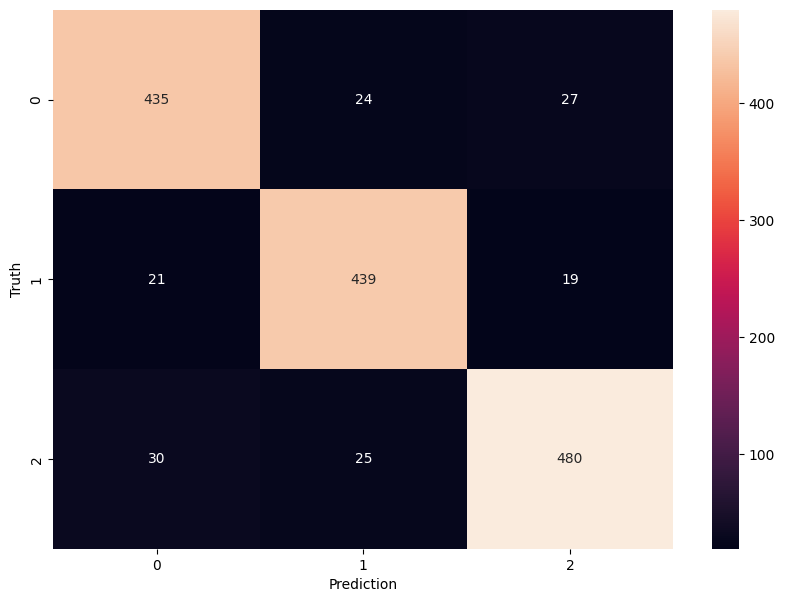

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_gb)
cm

from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')